# Experiment with Motion Models

- This notebook contains code for experiment with motion models. The purpose of the notebook is to study the error of motion models, which are commonly used in research.
- In this study, we assume that the heading of the user is identical to the heading of the mobile phone and the heading values are computed from quaternions.
- In this study, we explore three step models and three stride-length models, which are commonly used in passive crowd-sourcing methods for WiFi radio map construction.
  - Step Models: local acceleration variance based, angular rate based, auto-correlation based.
  - Stride-Length Models: random, Weinberg, ZUPT

## Import

In [1]:
import sys
import os

# Add paths for resolve 
INDOOR_COMPETITION_20_DIR = os.path.join("..", "indoor-location-competition-20")
sys.path.append(INDOOR_COMPETITION_20_DIR)
CODE_DIR = ".."
sys.path.append(CODE_DIR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

from py_indoor_loc.model import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.plot import plot_floor_map
from py_indoor_loc.sensors import compute_earth_acce_heading, compute_earth_acce_heading_ahrs
from py_indoor_loc.pdr.common import compute_step_heading, compute_rel_positions
from py_indoor_loc.pdr.common import RelPositionPredictor, compute_cumulative_step_positions
from py_indoor_loc.pdr.step_detection import AcfSDModel, LocalAcceVarianceSDModel, AngularRateSDModel
from py_indoor_loc.pdr.stride_length import WeinbergSLModel, ZUPTSLModel, RandomSLModel

In [3]:
from py_indoor_loc.pdr.stride_length import AbcSLModel

In [4]:
from compute_f import compute_step_positions

In [5]:
np.random.seed(19)

In [6]:
def compute_path_length(waypoint):
  return np.linalg.norm(waypoint[1:, 1:] - waypoint[:-1, 1:], axis=1).sum()


def compute_path_duration_secs(waypoint):
  return (waypoint[-1, 0] - waypoint[0, 0]) / 1000

In [7]:
def compute_error_metrics(actual_step_positions: np.ndarray, 
                          pred_step_positions: np.ndarray,
                          duration_step_size: int = 10) -> dict:
                          
  actual_path_length = compute_path_length(actual_step_positions[:, 1:])
  predicted_path_length = compute_path_length(pred_step_positions[:, 1:])

  actual_path_rel_timestamps = actual_step_positions[:, 0] - actual_step_positions[0, 0]
  pred_path_rel_timestamps = pred_step_positions[:, 0] - pred_step_positions[0, 0]

  n_segments = np.ceil(actual_path_rel_timestamps[-1] / duration_step_size / 1000).astype(np.int64)

  segments = []
  segment_ae = []
  segment_ape = []
  for k in range(n_segments):
    segments.append((k + 1) * duration_step_size)
    pl_true = compute_path_length(actual_step_positions[actual_path_rel_timestamps < (k + 1) * duration_step_size * 1000, 1:])
    pl_pred = compute_path_length(pred_step_positions[pred_path_rel_timestamps < (k + 1) * duration_step_size * 1000, 1:])
    segment_ae.append(abs(pl_pred - pl_true))
    segment_ape.append(abs(pl_pred - pl_true) / (pl_true + 1e-6))

  return {
    "actual_distance": actual_path_length,
    "predicted_distance": predicted_path_length,
    "distance_error": abs(predicted_path_length - actual_path_length),
    "distance_error_pct": abs((predicted_path_length - actual_path_length) / (actual_path_length + 1e-6)),
    "segments": segments,
    "segment_distance_error": segment_ae,
    "segment_distance_error_pct": segment_ape,
  }

## Experiment Setup

### Track Selection

* In this experiment, we only consider

In [8]:
TRAIN_DATA_DIR = "../../data/train/"

In [9]:
def list_tracks(site_id: str, floor_id: str, data_dir: str) -> list[str]:
  track_floor_path = os.path.join(data_dir, site_id, floor_id)
  return list(glob(track_floor_path + "/*.txt"))

* Compute length and duration of tracks

In [10]:
track_list = []

for site_path in glob(TRAIN_DATA_DIR + "/*"):
  site_id = os.path.basename(site_path)

  for floor_path in glob(site_path + "/*"):
    floor_id = os.path.basename(floor_path)
    
    for track_path in glob(floor_path + "/*.txt"):
      track_id = os.path.basename(track_path)[:-len(".txt")]
      
      track_list.append((site_id, floor_id, track_id))

In [11]:
len(track_list)

26925

In [9]:
count = 0

track_stats = []

for (site_id, floor_id, track_id) in tqdm(track_list):
  track_path = os.path.join(TRAIN_DATA_DIR, site_id, floor_id, track_id + ".txt")
  try:
    path_data_collection = read_data_file(track_path)
    duration = compute_path_duration_secs(path_data_collection.waypoint)
    track_stats.append({
      "site_id": site_id,
      "floor_id": floor_id,
      "track_id": track_id,
      "duration": compute_path_duration_secs(path_data_collection.waypoint),
      "length": compute_path_length(path_data_collection.waypoint),
    })

    if duration > 60:
      count += 1

    if count >= 30000:
      break
  
  except Exception as ignored:
    pass

 19%|█▉        | 5133/26925 [06:02<28:22, 12.80it/s]  

Failed to processing line: ['1559699299331', 'TYPE_ROTATION_VECTOR', '0.17401376', '-0.0031055238']. Caused by list index out of range


100%|██████████| 26925/26925 [42:10<00:00, 10.64it/s]  


In [11]:
track_stats_df = pd.DataFrame(track_stats)
track_stats_df.to_csv("../../data/track_stats.csv", index=False)

NameError: name 'track_stats' is not defined

In [12]:
track_stats_df = pd.read_csv("../../data/track_stats.csv")

In [13]:
track_stats_df = track_stats_df[track_stats_df["length"] >= 50].reset_index(drop=True)

## Result Analysis

In [8]:
result_df = pd.read_csv("../../data/Results_PDR_20231010.csv", sep=";", index_col=0)

In [36]:
result_df[(result_df["actual_distance"] >= 10)].groupby("model_name").agg({"distance_error_pct": "median", "model_name": "count"}).sort_values("distance_error_pct")

,distance_error_pct,model_name
model_name,,
acf + weinberg,0.200626,6726
local_acce_var + random,0.261407,6726
angular_rate + random,0.296054,6726
angular_rate + weinberg,0.348543,6726
local_acce_var + weinberg,0.516536,6726
acf + random,0.538434,6726
acf + zupt,0.549718,6726
angular_rate + zupt,2.368593,6726
local_acce_var + zupt,3.996783,6726


* Errors by time

In [11]:
data = []

for i, row in result_df[(result_df["actual_distance"] >= 10)].iterrows():
  for t, aep in zip(eval(row["segments"]), eval(row["segment_distance_error_pct"])):
    data.append([row["model_name"], t, aep])

In [12]:
df = pd.DataFrame(data, columns=["model_name", "time_sec", "aep"])

In [19]:
df["time_min"] = (np.floor(df["time_sec"] / 30) * 30).astype(np.int32)

In [20]:
models = df["model_name"].unique()

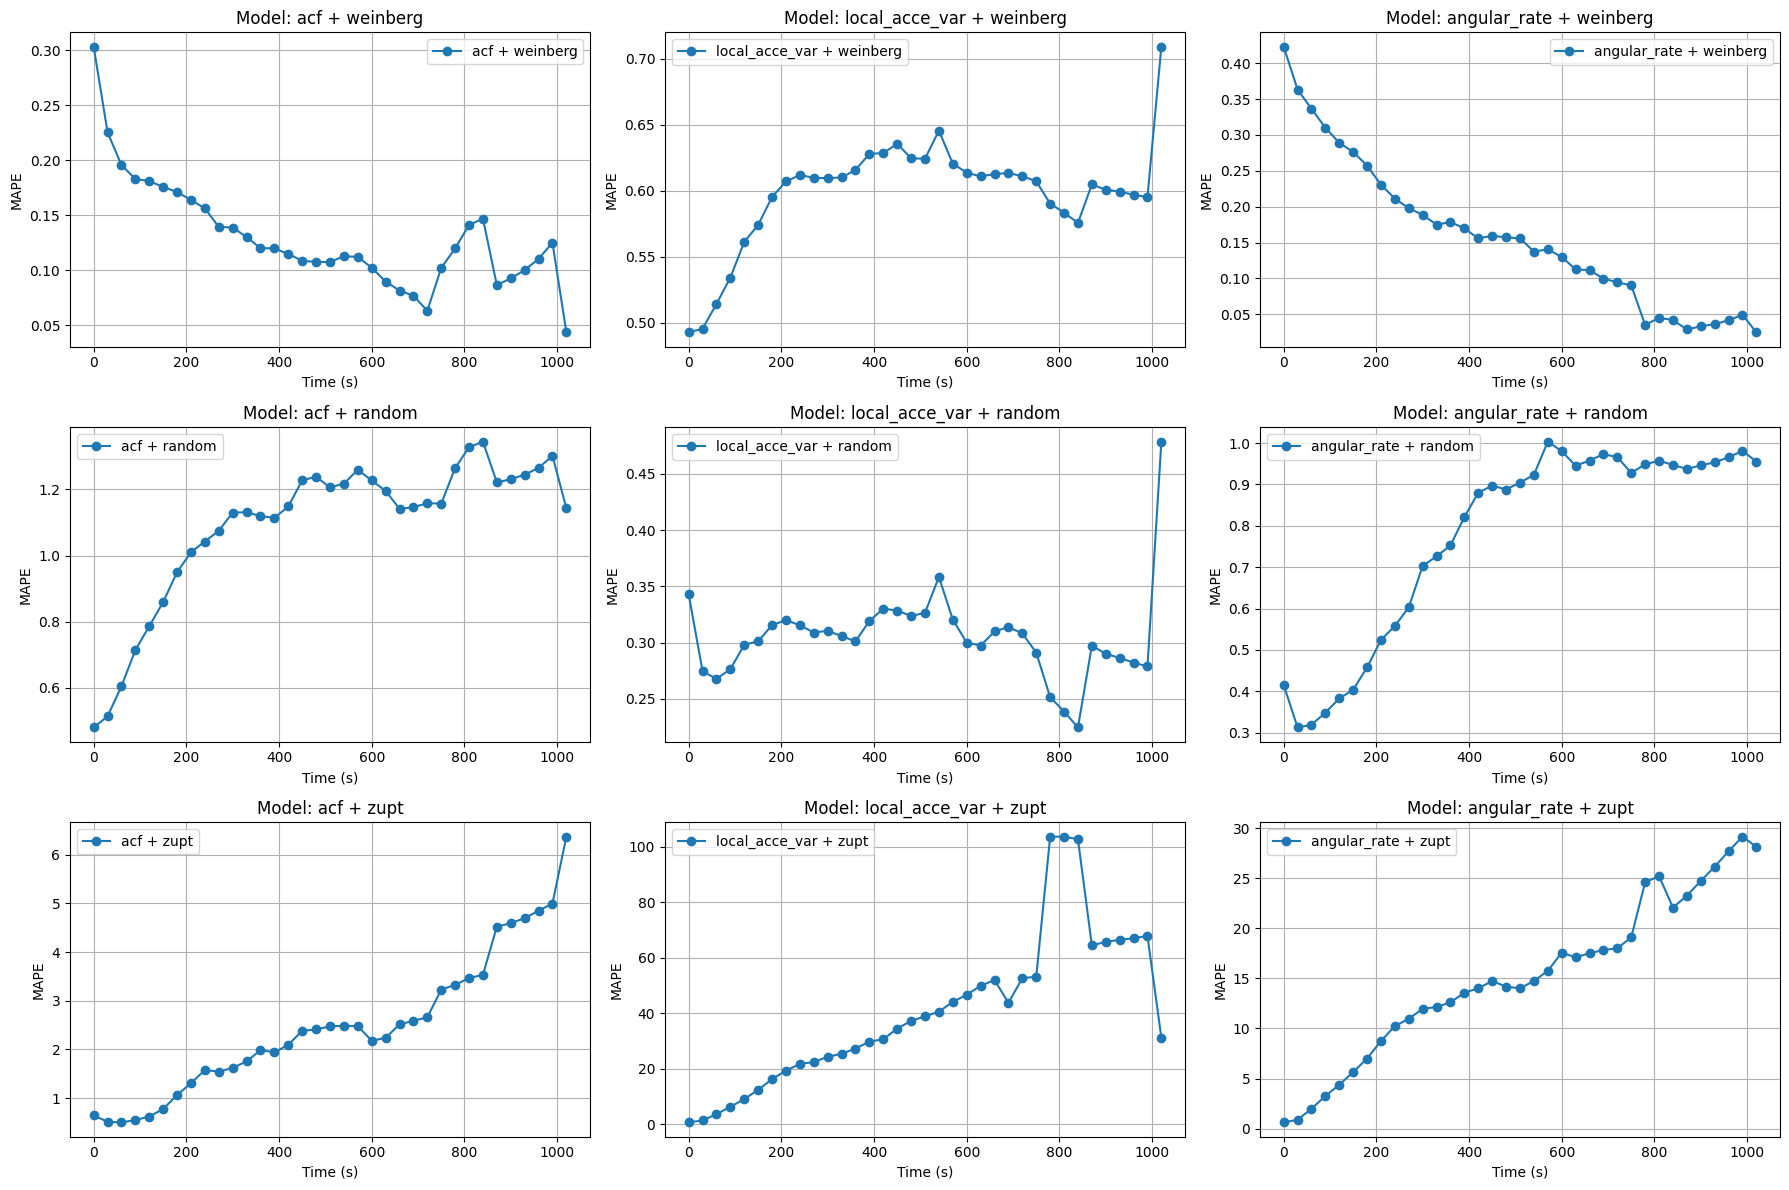

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, model in enumerate(models):
  r = i // 3
  c = i % 3

  sample = df.loc[df["model_name"] == model]
  aep = sample.groupby("time_min").apply(lambda rows: rows["aep"].median()).reset_index(name="mean_aep")

  axes[r, c].plot(aep["time_min"].values, aep["mean_aep"].values, marker="o", label=model)
  axes[r, c].legend()
  axes[r, c].set_title("Model: " + model)
  axes[r, c].set_xlabel("Time (s)")
  axes[r, c].set_ylabel("MAPE")
  axes[r, c].grid()

plt.tight_layout()
plt.show()

* An example track

In [27]:
def create_zupt_sl_model(step_detector, **kwargs):
  return ZUPTSLModel(step_detector, **kwargs)

local_acce_var_step_detector = LocalAcceVarianceSDModel(window_size=4, swing_threshold=2, stance_threshold=1, use_ahrs=True)
acf_step_detector = AcfSDModel(t_min=40, t_max=100, use_ahrs=True)
angular_rate_step_detector = AngularRateSDModel(median_filter_window_size=8, stance_threshold=0.4)

weinberg_sl_model = WeinbergSLModel(window_size=16, use_ahrs=True)
random_sl_model = RandomSLModel(base_sl=1.0, noise_pct=0.15)

zupt_local_acce_var_sl_model = create_zupt_sl_model(local_acce_var_step_detector, window_size=4, fs=50, use_ahrs=True)
zupt_acf_sl_model = create_zupt_sl_model(acf_step_detector, window_size=4, fs=50, use_ahrs=True)
zupt_angular_rate_sl_model = create_zupt_sl_model(angular_rate_step_detector, window_size=4, fs=50, use_ahrs=True)


acf_weinberg = RelPositionPredictor(sd_model=acf_step_detector,
                                    sl_model=weinberg_sl_model,
                                    name="acf + weinberg")

local_acce_var_weinberg = RelPositionPredictor(
    sd_model=local_acce_var_step_detector,
    sl_model=weinberg_sl_model,
    name="local_acce_var + weinberg")

angular_rate_weinberg = RelPositionPredictor(
    sd_model=angular_rate_step_detector,
    sl_model=weinberg_sl_model,
    name="angular_rate + weinberg")

acf_random = RelPositionPredictor(sd_model=acf_step_detector,
                                  sl_model=random_sl_model,
                                  name="acf + random")

local_acce_var_random = RelPositionPredictor(
    sd_model=local_acce_var_step_detector,
    sl_model=random_sl_model,
    name="local_acce_var + random")

angular_rate_random = RelPositionPredictor(sd_model=angular_rate_step_detector,
                                           sl_model=random_sl_model,
                                           name="angular_rate + random")

acf_zupt = RelPositionPredictor(sd_model=zupt_acf_sl_model.step_detection_model,
                                sl_model=zupt_acf_sl_model,
                                name="acf + zupt")

local_acce_var_zupt = RelPositionPredictor(
    sd_model=zupt_local_acce_var_sl_model.step_detection_model,
    sl_model=zupt_local_acce_var_sl_model,
    name="local_acce_var + zupt")

angular_rate_zupt = RelPositionPredictor(
    sd_model=zupt_angular_rate_sl_model.step_detection_model,
    sl_model=zupt_angular_rate_sl_model,
    name="angular_rate + zupt")

models = [
  acf_weinberg,
  local_acce_var_weinberg,
  angular_rate_weinberg,
  acf_random,
  local_acce_var_random,
  angular_rate_random,
  acf_zupt,
  local_acce_var_zupt,
  angular_rate_zupt
]

In [68]:
path_data_collection = read_data_file("../../data/train/5d27075f03f801723c2e360f/F1/5da6c04caee18f0006a0ef18.txt")

In [69]:
actual_step_positions = compute_step_positions(path_data_collection.acce,
                                               path_data_collection.ahrs,
                                               path_data_collection.waypoint)


In [74]:
model_predicted_results = []

for model in models:
  pred_rel_positions = model.predict(path_data_collection)
  pred_step_positions = compute_cumulative_step_positions(pred_rel_positions)
  model_predicted_results.append(pred_step_positions)

In [71]:
actual_step_rel_positions = actual_step_positions[:, :] - actual_step_positions[0, :]

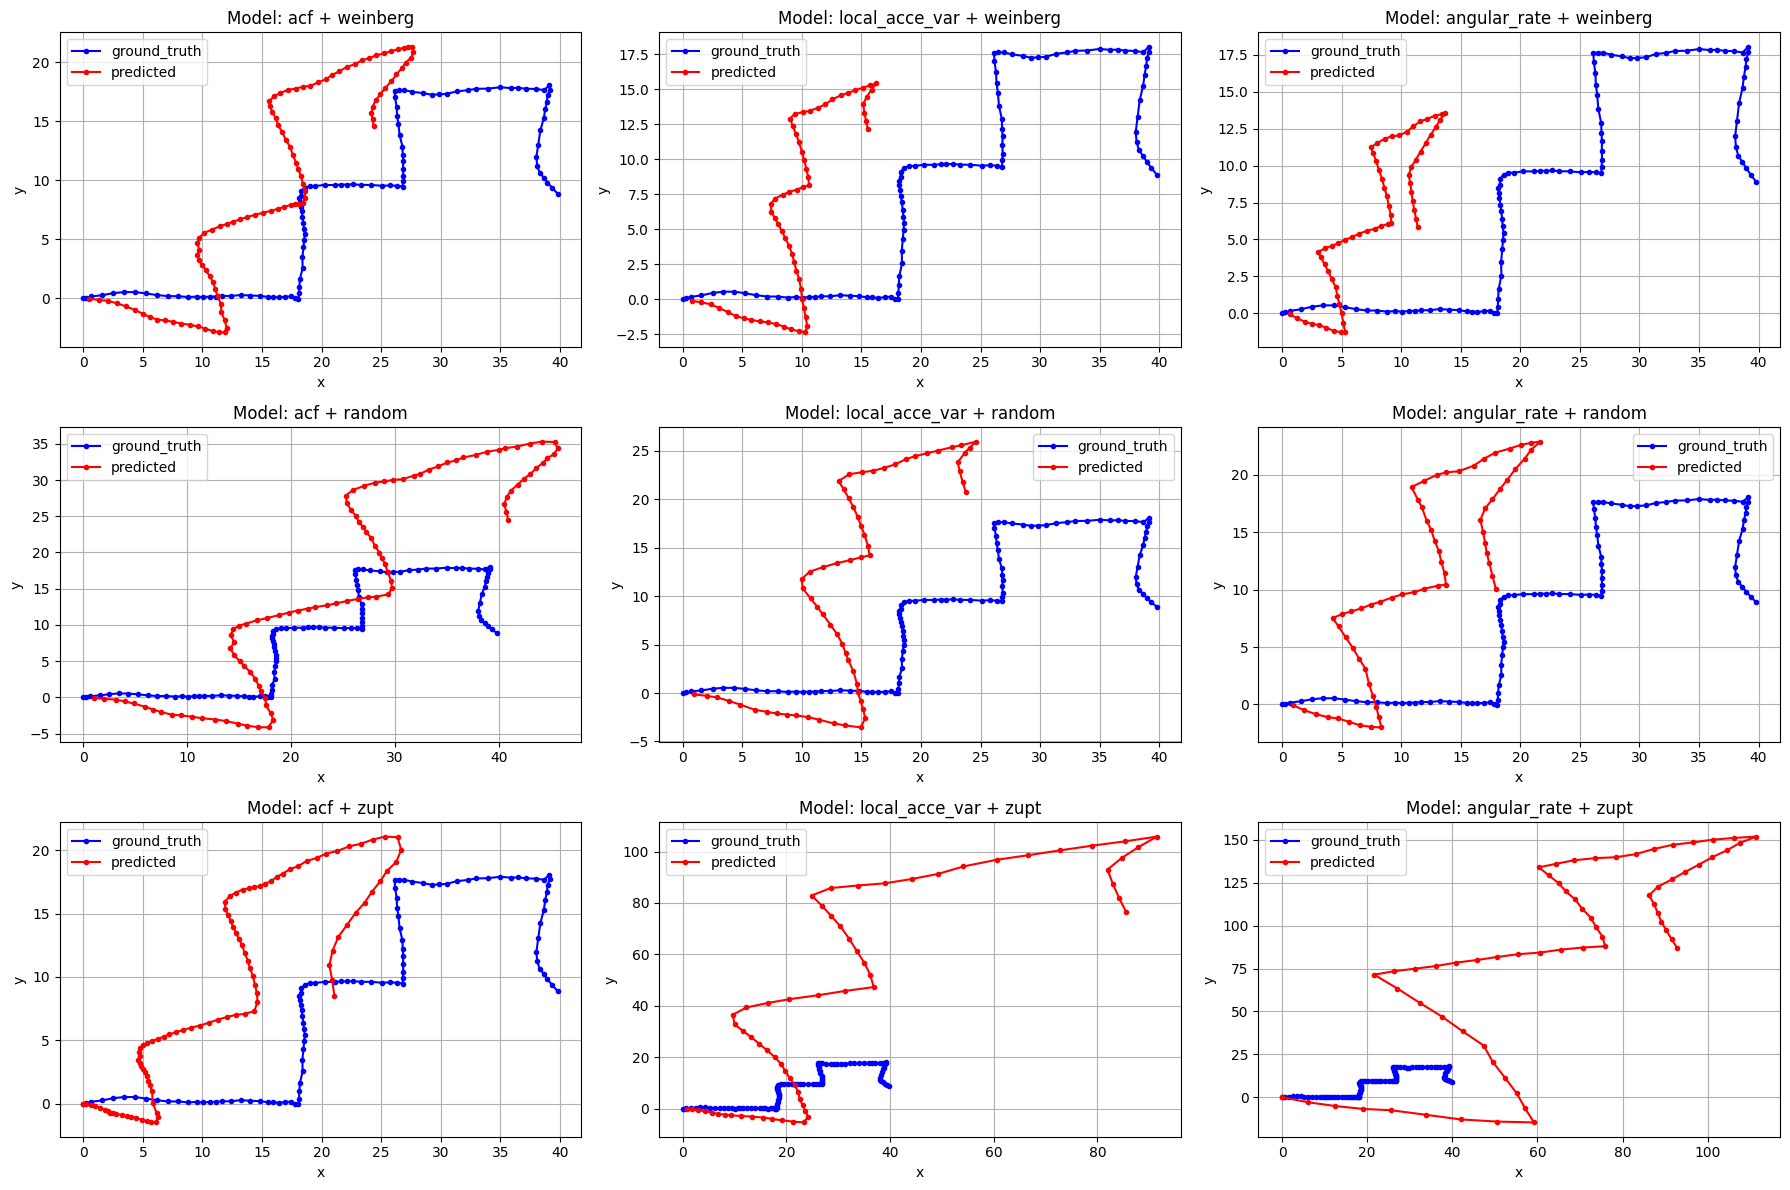

In [78]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, model in enumerate(models):
  r = i // 3
  c = i % 3

  pred_step_positions = model_predicted_results[i] 

  axes[r, c].plot(actual_step_rel_positions[:, 1], 
          actual_step_rel_positions[:, 2], marker=".", color="blue", label="ground_truth")

  axes[r, c].plot(pred_step_positions[:, 1], 
          pred_step_positions[:, 2], marker=".", color="red", label="predicted")
  axes[r, c].legend()
  axes[r, c].grid()
  axes[r, c].set_title(f"Model: {model.name}")
  axes[r, c].set_xlabel("x")
  axes[r, c].set_ylabel("y")

plt.tight_layout()
plt.show()

In [ ]:
def run_experiment(site_floor_tracks, model):

  experiment_results = []

  for site_id, floor_id, track_id in site_floor_tracks:
    track_path = os.path.join(TRAIN_DATA_DIR, site_id, floor_id, track_id + ".txt")

    try:
      path_data_collection = read_data_file(track_path)
      actual_step_positions = compute_step_positions(path_data_collection.acce, path_data_collection.ahrs, path_data_collection.waypoint)

      pred_rel_positions = model.predict(path_data_collection)
      pred_step_positions = compute_cumulative_step_positions(pred_rel_positions)
      result = compute_error_metrics(actual_step_positions, pred_step_positions)
      result.update({
        "site_id": site_id,
        "floor_id": floor_id,
        "track_id": track_id,
        "model_name": model.name,
      })
      experiment_results.append(result)

    except Exception as e:
      print(f"Error: {type(e)}: {str(e)}")
  
  return experiment_results